# Pre-Paid Card Marketing

## Data Preprocessing

In [146]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import loguniform, randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier

import utils

In [148]:
df = pd.read_csv('../data/Financial Wellness Data.csv')
df

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
0,10350,2,3,5,5,6,55,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
1,7740,1,3,6,6,6,51,2,2,3,...,1,2,3,0,0,0,0,2,0,1.327561
2,13699,1,3,4,3,4,49,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
3,7267,1,3,6,6,6,49,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
4,7375,1,3,4,4,4,49,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,11220,3,3,6,7,7,61,3,3,1,...,1,2,3,0,0,0,1,2,-5,0.522504
6390,13118,3,2,7,7,7,59,3,4,2,...,1,3,6,0,0,0,0,3,-5,1.015219
6391,8709,1,3,5,6,6,59,3,4,3,...,1,1,2,0,0,0,0,2,0,1.136270
6392,8515,1,3,5,5,5,46,2,2,3,...,1,4,9,0,0,0,0,2,0,1.224941


In [149]:
# find duplicates
df[df.duplicated()]

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt


In [150]:
# check for missing values
df.isnull().sum()

PUF_ID         0
sample         0
fpl            0
SWB_1          0
SWB_2          0
              ..
PPT612         0
PPT1317        0
PPT18OV        0
PCTLT200FPL    0
finalwt        0
Length: 217, dtype: int64

In [151]:
# check the data types
df.dtypes

PUF_ID           int64
sample           int64
fpl              int64
SWB_1            int64
SWB_2            int64
                ...   
PPT612           int64
PPT1317          int64
PPT18OV          int64
PCTLT200FPL      int64
finalwt        float64
Length: 217, dtype: object

In [152]:
# check if any features have zero variance
df.var() == 0

PUF_ID         False
sample         False
fpl            False
SWB_1          False
SWB_2          False
               ...  
PPT612         False
PPT1317        False
PPT18OV        False
PCTLT200FPL    False
finalwt        False
Length: 217, dtype: bool

## Exploratory Data Analysis

In [156]:
# Describe the data
df.describe()

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
count,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,...,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000
mean,10892.392712,1.279794,2.658899,5.353769,5.362215,5.432280,56.034094,3.048014,3.191899,2.531279,...,0.866124,2.644823,5.145605,0.035815,0.078511,0.129653,0.122928,2.084298,-0.081952,1.000000
std,1967.854493,0.570187,0.656944,1.500913,1.544942,1.613876,14.154676,1.235221,1.114130,1.196235,...,0.340545,1.032583,2.529397,0.185843,0.268995,0.335947,0.328380,0.814345,1.328498,0.585406
min,7123.000000,1.000000,1.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-5.000000,0.165567
25%,9235.250000,1.000000,3.000000,5.000000,5.000000,5.000000,48.000000,2.000000,3.000000,2.000000,...,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.600582
50%,10901.500000,1.000000,3.000000,6.000000,6.000000,6.000000,56.000000,3.000000,3.000000,2.000000,...,1.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.845213
75%,12570.750000,1.000000,3.000000,6.000000,7.000000,7.000000,65.000000,4.000000,4.000000,3.000000,...,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.251415
max,14400.000000,3.000000,3.000000,7.000000,7.000000,7.000000,95.000000,5.000000,5.000000,5.000000,...,1.000000,4.000000,9.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,6.638674


## Feature Engineering

In [163]:
# Split the data into features and target
X = df.drop(columns=['PUF_ID', 'PRODUSE_3'])
y = df['PRODUSE_3']

In [164]:
# drop some variables
X = X.drop(columns=['finalwt', 'PRODUSE_6'])
X

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMARIT,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL
0,2,3,5,5,6,55,3,3,3,3,...,3,1,4,8,0,0,0,0,1,0
1,1,3,6,6,6,51,2,2,3,3,...,3,1,2,3,0,0,0,0,2,0
2,1,3,4,3,4,49,3,3,3,3,...,3,1,4,9,0,0,0,1,2,1
3,1,3,6,6,6,49,3,3,3,3,...,3,1,3,7,0,0,0,0,1,0
4,1,3,4,4,4,49,3,3,3,3,...,1,1,2,4,0,0,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,3,3,6,7,7,61,3,3,1,3,...,1,1,2,3,0,0,0,1,2,-5
6390,3,2,7,7,7,59,3,4,2,4,...,1,1,3,6,0,0,0,0,3,-5
6391,1,3,5,6,6,59,3,4,3,3,...,1,1,1,2,0,0,0,0,2,0
6392,1,3,5,5,5,46,2,2,3,2,...,5,1,4,9,0,0,0,0,2,0


<Axes: xlabel='PRODUSE_3'>

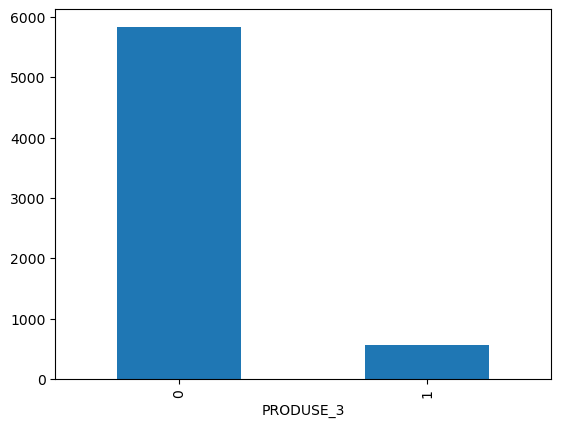

In [165]:
# plot the distribution of the target variable
y.value_counts().plot(kind='bar')

### Dummify the categorical variables

In [166]:
# dummify any integer columns
df_categorical = X.astype('object')

# dummify the categorical variables
X = pd.get_dummies(df_categorical, drop_first=True)
X

,sample_2,sample_3,fpl_2,fpl_3,SWB_1_-1,SWB_1_1,SWB_1_2,SWB_1_3,SWB_1_4,SWB_1_5,...,PPREG9_9,PPT01_1,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_2,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0,PCTLT200FPL_1
0,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,False,False,False,True,False,False,False,False,True,False,...,True,False,False,False,True,True,False,False,False,True
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,True,False,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
6390,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6391,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
6392,False,False,False,True,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,True,False


In [167]:
# convert the one-hot encoded data to integers
X = X.astype('float64')
X

,sample_2,sample_3,fpl_2,fpl_3,SWB_1_-1,SWB_1_1,SWB_1_2,SWB_1_3,SWB_1_4,SWB_1_5,...,PPREG9_9,PPT01_1,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_2,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0,PCTLT200FPL_1
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6390,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6391,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6392,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Remove Highly Correlated Features

In [170]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X, correlation_threshold=0.95, variance_threshold=0.05)
X_vif

Removed highly correlated variables: ['DISCOUNT_2', 'BENEFITS_1_1', 'KHKNOWL5_2', 'KHKNOWL4_2', 'KH6correct_1', 'KH3correct_1', 'EMPLOY1_8_1', 'SOCSEC2_-2', 'FK3correct_1', 'FINSOC2_1_1', 'FINSOC2_3_1', 'KH5correct_1', 'FINSOC2_2_1', 'KH4correct_1', 'KH8correct_1', 'KH7correct_1', 'BENEFITS_5_1', 'KHKNOWL9_2', 'KH9correct_1', 'FINSOC2_5_1', 'FINSOC2_4_1', 'FINSOC2_7_1', 'FK2correct_1', 'EMPLOY1_2_1', 'Military_Status_5', 'BENEFITS_4_1', 'FINGOALS_1', 'FK1correct_1', 'BENEFITS_2_1', 'FINKNOWL3_2', 'KHKNOWL6_2', 'KH2correct_1', 'BENEFITS_3_1', 'KH1correct_1', 'ON1correct_1', 'FINSOC2_6_1', 'MILITARY_1']


Removed variable: PCTLT200FPL_0 with VIF: 1256968274949549.25
Removed variable: PPREG4_4 with VIF: 406693750777004.31
Removed variable: FWB2_2_3 with VIF: 3303.44
Removed variable: LMscore_3 with VIF: 2038.76
Removed variable: FWB1_4_3 with VIF: 1338.16
Removed variable: FWB2_1_2 with VIF: 1135.32
Removed variable: MANAGE1_3_5 with VIF: 562.24
Removed variable: FWB1_5_3 with VIF: 516.36
Removed variable: FWB2_4_3 with VIF: 422.49
Removed variable: FWB1_1_3 with VIF: 349.57
Removed variable: FS1_5_3 with VIF: 281.55
Removed variable: FWB1_2_3 with VIF: 267.06
Removed variable: KHKNOWL1_3 with VIF: 248.27
Removed variable: KHscore_0.712 with VIF: 223.56
Removed variable: FINKNOWL2_3 with VIF: 214.17
Removed variable: SOCSEC1_1 with VIF: 140.77
Removed variable: KIDS_4_0 with VIF: 121.94
Removed variable: KHKNOWL2_3 with VIF: 119.19
Removed variable: HOUSING_1 with VIF: 90.33
Removed variable: DISTRESS_3 with VIF: 81.78
Removed variable: FINKNOWL1_1 with VIF: 74.05
Removed variable: FRAUD

,sample_2,sample_3,fpl_2,SWB_1_4,SWB_1_5,SWB_1_6,SWB_2_4,SWB_2_5,SWB_2_6,SWB_2_7,...,PPREG9_5,PPREG9_7,PPREG9_8,PPREG9_9,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_3,PPT18OV_4,PCTLT200FPL_1
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6390,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6391,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split the Data

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2, stratify=y, random_state=42)

### Logistic Regression to Find Important Features

In [219]:
X_train_const = sm.add_constant(X_train)

logit_model_reg = sm.Logit(y_train, X_train_const).fit(maxiter=1000)
print(logit_model_reg.summary())

Optimization terminated successfully.
         Current function value: 0.215720
         Iterations 211
                           Logit Regression Results                           
Dep. Variable:              PRODUSE_3   No. Observations:                 5115
Model:                          Logit   Df Residuals:                     4706
Method:                           MLE   Df Model:                          408
Date:                Fri, 08 Nov 2024   Pseudo R-squ.:                  0.2735
Time:                        22:56:55   Log-Likelihood:                -1103.4
converged:                       True   LL-Null:                       -1518.7
Covariance Type:            nonrobust   LLR p-value:                 4.339e-31
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -37.7855   1.81e+07  -2.09e-06      1.000   -3.55e+07    3.5

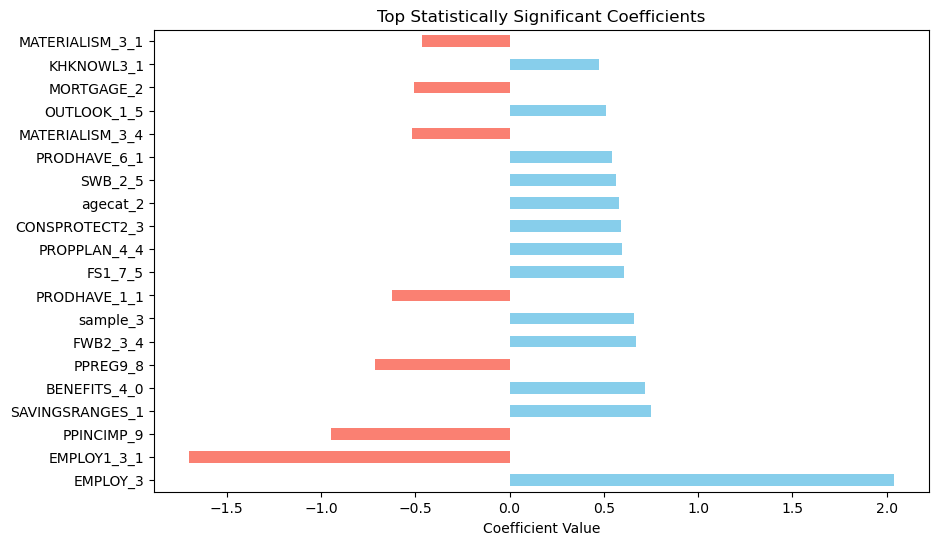

In [220]:
# Get the coefficients and p-values
coefficients = logit_model_reg.params
p_values = logit_model_reg.pvalues

# Create a DataFrame to hold coefficients and p-values for easier processing
coef_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values
})

# Filter out statistically significant coefficients (e.g., p-value < 0.05)
significant_coefs = coef_df[coef_df['P-Value'] < 0.05]

# Sort coefficients by absolute value (to find the top 20 largest), keeping the sign
top_coefs = significant_coefs['Coefficient'].abs().sort_values(ascending=False).head(20).index

# Filter the original coefficients DataFrame to get the top 20 largest coefficients (with signs)
top_coefs_with_signs = significant_coefs.loc[top_coefs]

# Plot the top 20 largest coefficients with their signs
plt.figure(figsize=(10, 6))
top_coefs_with_signs['Coefficient'].plot(kind='barh', color=['skyblue' if coeff >= 0 else 'salmon' for coeff in
                                                             top_coefs_with_signs['Coefficient']])
plt.xlabel('Coefficient Value')
plt.title('Top Statistically Significant Coefficients')
plt.show()

In [222]:
# take the top coefficients and create a new dataframe
top_features = top_coefs_with_signs.index

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# reset the index
X_train_top.reset_index(drop=True, inplace=True)
X_test_top.reset_index(drop=True, inplace=True)
X_train_top

,EMPLOY_3,EMPLOY1_3_1,PPINCIMP_9,SAVINGSRANGES_1,BENEFITS_4_0,PPREG9_8,FWB2_3_4,sample_3,PRODHAVE_1_1,FS1_7_5,PROPPLAN_4_4,CONSPROTECT2_3,agecat_2,SWB_2_5,PRODHAVE_6_1,MATERIALISM_3_4,OUTLOOK_1_5,MORTGAGE_2,KHKNOWL3_1,MATERIALISM_3_1
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5111,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5113,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0


## Model Building

### Scoring and Cross-Validation

In [223]:
# Define a custom scorer
scorer = make_scorer(f1_score)

In [224]:
# Create a stratified k-fold object to ensure class balance across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

In [225]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)

In [226]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],  # Regularization type
    'C': loguniform(1e-4, 1e4),  # Regularization strength (inverse of alpha)
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solver options
    'l1_ratio': [0.1, 0.5, 0.9],  # ElasticNet mixing (only for 'elasticnet' penalty)
    'max_iter': [100, 500, 1000]  # Max iterations
}


#### RandomizedSearchCV

In [227]:
# Perform GridSearchCV
# Create a GridSearchCV object
logit_random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dist_lr,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

logit_random_search.fit(X_train_top, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1197: User

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x37f433a50>,
                                        'l1_ratio': [0.1, 0.5, 0.9],
                                        'max_iter': [100, 500, 1000],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'None'],
                                        'solver': ['liblinear', 'saga',
                                                   'lbfgs']},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

#### Best Parameters and Best Score

In [228]:
# Print the best parameters and score
print("Best Parameters: ", logit_random_search.best_params_)
print("Best Score: ", logit_random_search.best_score_)

Best Parameters:  {'C': 5744.851636320435, 'l1_ratio': 0.5, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best Score:  0.05878207940337793


In [229]:
# evaluate the model with the best hyperparameters
y_pred_lr_hyper = logit_random_search.predict(X_test_top)

#### Classification Report

In [230]:
# Print the classification report
print(classification_report(y_test, y_pred_lr_hyper))

              precision    recall  f1-score   support

           0       0.92      1.00      0.95      1167
           1       0.57      0.04      0.07       112

    accuracy                           0.91      1279
   macro avg       0.74      0.52      0.51      1279
weighted avg       0.89      0.91      0.88      1279



### XGBoost

In [231]:
xgb_model = XGBClassifier(random_state=42)

In [232]:
# Define the parameter distribution for GridSearchCV
param_distributions_xgb = {
    'n_estimators': randint(100, 1000),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinkage
    'max_depth': randint(3, 15),  # Maximum depth of a tree
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': uniform(0, 0.5),  # Minimum loss reduction to make a split
    'subsample': uniform(0.1, 0.9),  # Subsample ratio of the training data
    'colsample_bytree': uniform(0.1, 0.9),  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': randint(1, 10),  # Controls the balance of positive and negative classes
}

#### RandomizedSearchCV

In [233]:
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random_search.fit(X_train_top, y_train, verbose=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x300b4f0d0>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x371ece2d0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x371ecd350>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

#### Best Parameters and Best Score

In [234]:
# Print the best parameters and score
print("Best Parameters: ", xgb_random_search.best_params_)
print("Best Score: ", xgb_random_search.best_score_)

Best Parameters:  {'colsample_bytree': 0.1826191592320977, 'gamma': 0.04707849413428006, 'learning_rate': 0.10342399281738825, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 303, 'scale_pos_weight': 5, 'subsample': 0.5261245937025091}
Best Score:  0.2906535719150872


In [235]:
# evaluate the model with the best hyperparameters
y_pred_xgb_hyper = xgb_random_search.predict(X_test_top)

#### Classification Report

In [236]:
# Print the classification report
print(classification_report(y_test, y_pred_xgb_hyper))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1167
           1       0.20      0.29      0.23       112

    accuracy                           0.84      1279
   macro avg       0.56      0.59      0.57      1279
weighted avg       0.86      0.84      0.85      1279



### ANN

In [244]:
# use keras to build an ANN
model = Sequential()
model.add(Dense(16, input_shape=(X_train_top.shape[1],), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[utils.f1_score])
ann = model.fit(X_train_top, y_train, epochs=1000, callbacks=[early_stop], validation_split=0.3, verbose=0)
model.summary()

/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 36: early stopping


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_109 (Dense)               │ (None, 16)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,541 (6.02 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,028 (4.02 KB)

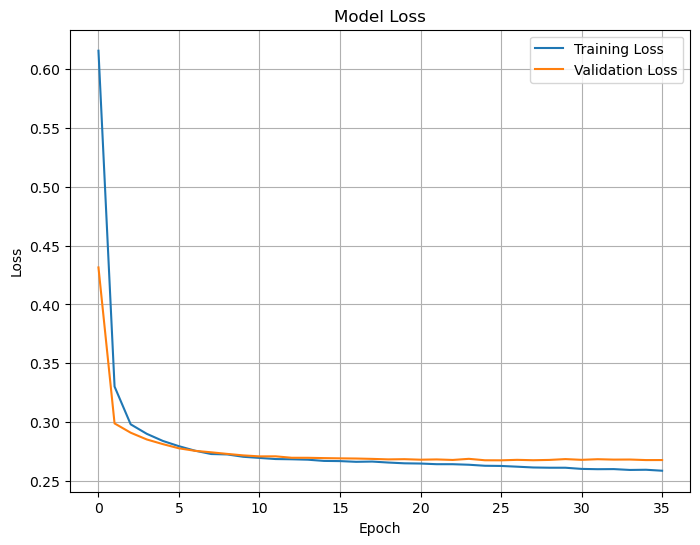

In [245]:
utils.plot_loss(ann)

#### Classification Report

In [246]:
y_pred_proba_ann = model.predict(X_test_top)
y_pred_ann = [1 if prob > 0.15 else 0 for prob in y_pred_proba_ann]
print(classification_report(y_test, y_pred_ann))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1167
           1       0.19      0.36      0.24       112

    accuracy                           0.81      1279
   macro avg       0.56      0.60      0.57      1279
weighted avg       0.87      0.81      0.83      1279

